<div style = "color: Black; 
              display: fill;
              border-radius: 12px;
              background-color: #c7a48b;
              box-shadow: rgba(0, 0, 0, 0.15) 0px 10px 5px, rgba(0, 0, 0, 0.12) 0px 6px 6px;">
    <h1 id = "preparation"
        style = "padding: 13px; 
                 color: White;
                 font-size: 24px;
                 font-weight: bold;
                 font-family: Calibri;">1. | Preparation
        <a class="anchor-link" id="preparation" href="https://www.kaggle.com/code/harits/vgg16-asl-recognition-model-explainability#preparation">¶</a>
    </h1>
</div>

In [16]:
!pip install imutils

## import library

In [17]:
# Import Libraries

# Warning
import warnings
warnings.filterwarnings("ignore")

# Main
import os
import glob
import cv2
import numpy as np
import pandas as pd
import gc
import string
import time
import random
import imutils
from PIL import Image
from tqdm import tqdm
tqdm.pandas()

# Visualization
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.manifold import TSNE

# Model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from keras.models import load_model, Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [18]:
# Configuration
class CFG:
    batch_size = 64
    img_height = 128
    img_width = 128
    epochs = 20
    num_classes = 29
    img_channels = 3
    
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

<div style = "color: Black; 
              display: fill;
              border-radius: 12px;
              background-color: #c7a48b;
              box-shadow: rgba(0, 0, 0, 0.15) 0px 10px 5px, rgba(0, 0, 0, 0.12) 0px 6px 6px;">
    <h1 id = "dataset"
        style = "padding: 13px; 
                 color: White;
                 font-size: 24px;
                 font-weight: bold;
                 font-family: Calibri;">2. | Dataset
        <a class="anchor-link" id="dataset" href="https://www.kaggle.com/code/harits/vgg16-asl-recognition-model-explainability#dataset">¶</a>
    </h1>
</div>

<div>
    <h2 style = "color: #c7a48b; font-size: 22px; font-family: Calibri; font-weight: bold;">2.1. Data Exploration</h2>
</div>

In [19]:
# Labels
TRAIN_PATH = "/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"
labels = []
alphabet = list(string.ascii_uppercase)
labels.extend(alphabet)
labels.extend(["del", "nothing", "space"])
print(labels)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [20]:
def sample_images(labels):
    # Create Subplots
    y_size = 12
    if(len(labels)<10):
        y_size = y_size * len(labels) / 10
    fig, axs = plt.subplots(len(labels), 9, figsize=(y_size, 13))

    for i, label in enumerate(labels):
        axs[i, 0].text(0.5, 0.5, label, ha='center', va='center', fontsize=8)
        axs[i, 0].axis('off')

        label_path = os.path.join(TRAIN_PATH, label)
        list_files = os.listdir(label_path)

        for j in range(8):
            img_label = cv2.imread(os.path.join(label_path, list_files[j]))
            img_label = cv2.cvtColor(img_label, cv2.COLOR_BGR2RGB)
            axs[i, j+1].imshow(img_label)
            axs[i, j+1].axis("off")

    # Title
    plt.suptitle("Sample Images in ASL Alphabet Dataset", x=0.55, y=0.92)

    # Show
    plt.show()

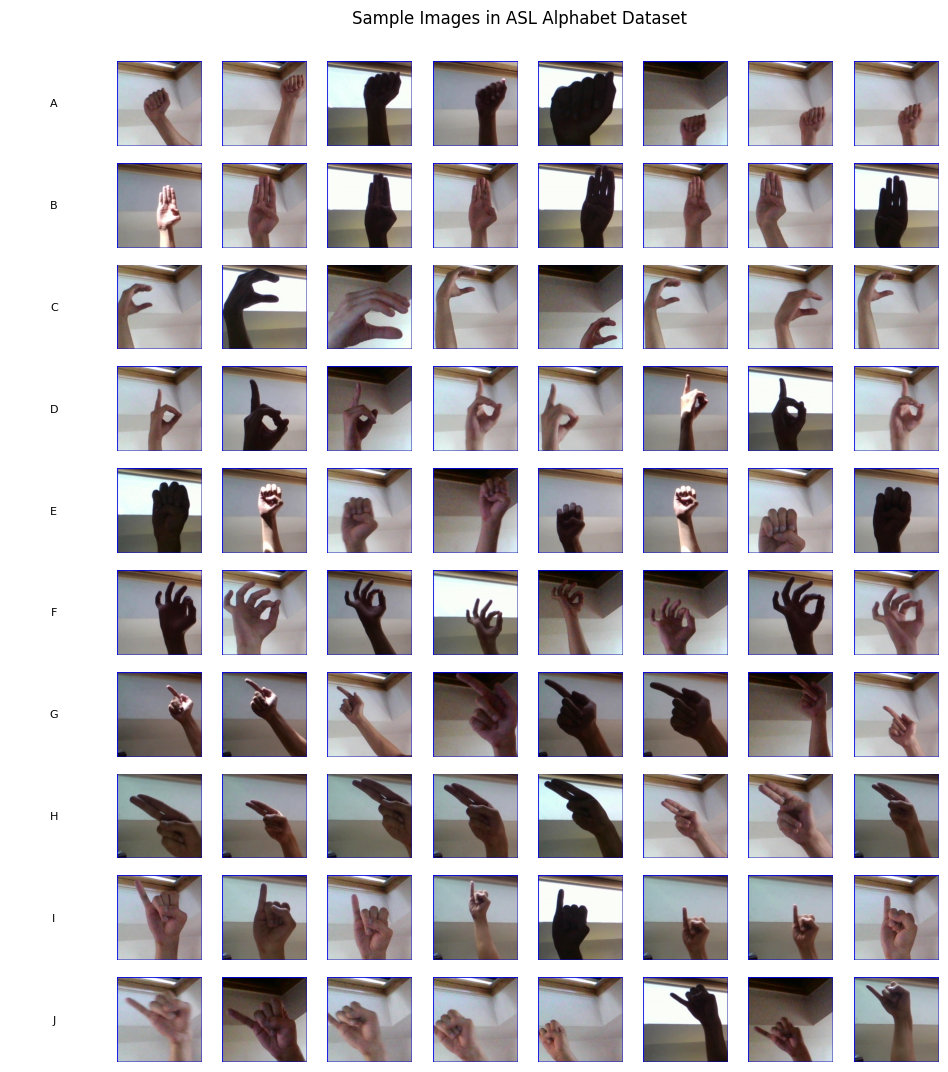

In [21]:
sample_images(labels[:10])

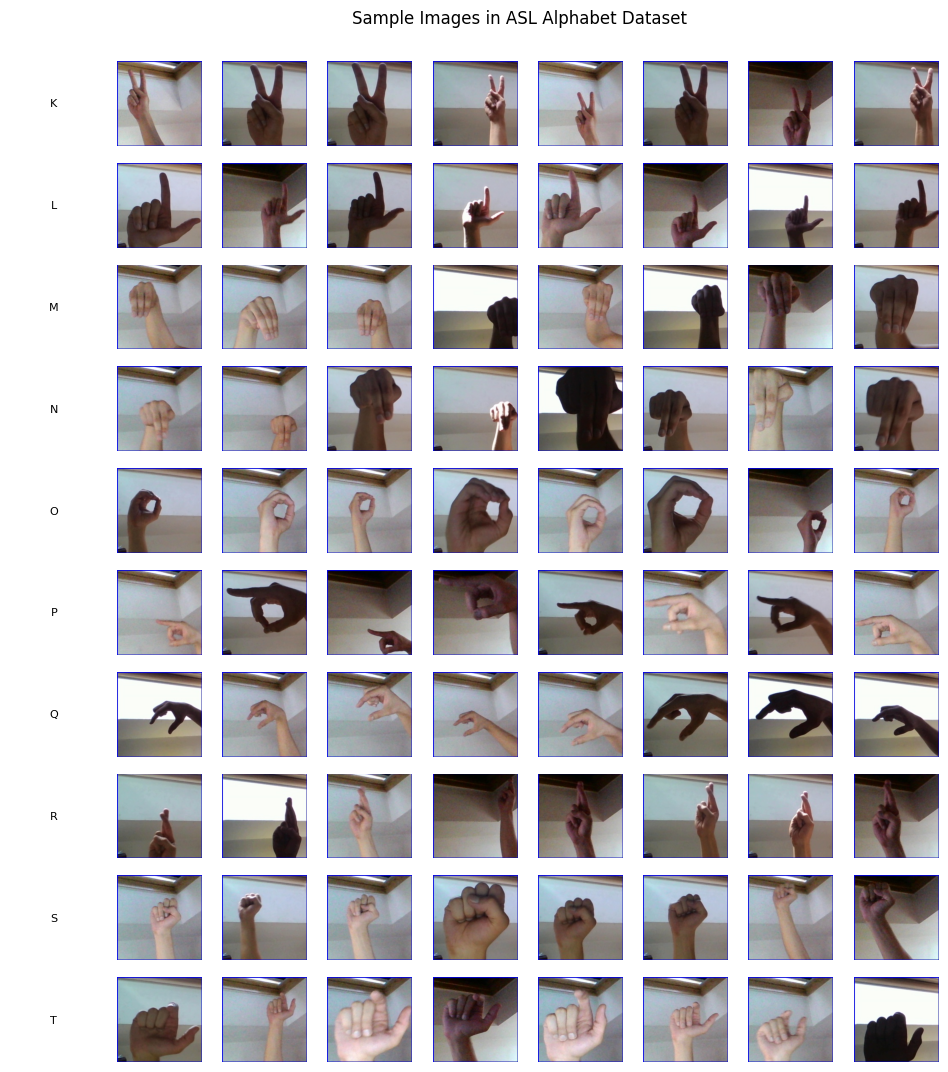

In [22]:
sample_images(labels[10:20])

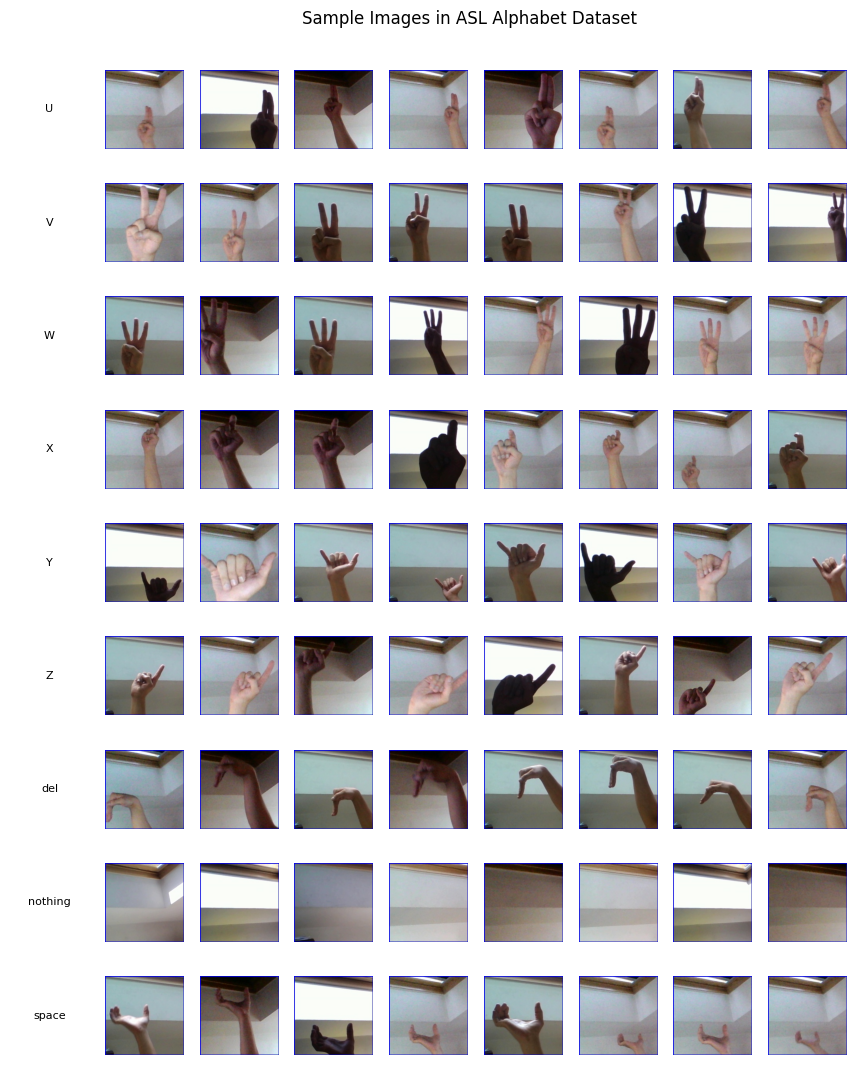

In [23]:
sample_images(labels[20:])

<div>
    <h2 style = "color: #c7a48b; font-size: 22px; font-family: Calibri; font-weight: bold;">2.2. Data Preprocessing</h2>
</div>

In [24]:
# Create Metadata
list_path = []
list_labels = []
for label in labels:
    label_path = os.path.join(TRAIN_PATH, label, "*")
    image_files = glob.glob(label_path)
    
    sign_label = [label] * len(image_files)
    
    list_path.extend(image_files)
    list_labels.extend(sign_label)

metadata = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})

metadata

image_path  label
0      /kaggle/input/asl-alphabet/asl_alphabet_train/...      A
1      /kaggle/input/asl-alphabet/asl_alphabet_train/...      A
2      /kaggle/input/asl-alphabet/asl_alphabet_train/...      A
3      /kaggle/input/asl-alphabet/asl_alphabet_train/...      A
4      /kaggle/input/asl-alphabet/asl_alphabet_train/...      A
...                                                  ...    ...
86995  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space
86996  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space
86997  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space
86998  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space
86999  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space

[87000 rows x 2 columns]

In [25]:
# Split Dataset to Train 0.7, Val 0.15, and Test 0.15
X_train, X_test, y_train, y_test = train_test_split(
    metadata["image_path"], metadata["label"], 
    test_size=0.15, 
    random_state=2023, 
    shuffle=True, 
    stratify=metadata["label"]
)
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})

X_train, X_val, y_train, y_val = train_test_split(
    data_train["image_path"], data_train["label"],
    test_size=0.15/0.70,
    random_state=2023,
    shuffle=True,
    stratify=data_train["label"]
)
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})
data_val = pd.DataFrame({
    "image_path": X_val,
    "label": y_val
})
data_test = pd.DataFrame({
    "image_path": X_test,
    "label": y_test
})

display(data_train)
display(data_val)
display(data_test)

image_path    label
51901  /kaggle/input/asl-alphabet/asl_alphabet_train/...        R
51887  /kaggle/input/asl-alphabet/asl_alphabet_train/...        R
5050   /kaggle/input/asl-alphabet/asl_alphabet_train/...        B
29446  /kaggle/input/asl-alphabet/asl_alphabet_train/...        J
58405  /kaggle/input/asl-alphabet/asl_alphabet_train/...        T
...                                                  ...      ...
47111  /kaggle/input/asl-alphabet/asl_alphabet_train/...        P
83611  /kaggle/input/asl-alphabet/asl_alphabet_train/...  nothing
67329  /kaggle/input/asl-alphabet/asl_alphabet_train/...        W
85296  /kaggle/input/asl-alphabet/asl_alphabet_train/...    space
60158  /kaggle/input/asl-alphabet/asl_alphabet_train/...        U

[58103 rows x 2 columns]

image_path label
24961  /kaggle/input/asl-alphabet/asl_alphabet_train/...     I
71053  /kaggle/input/asl-alphabet/asl_alphabet_train/...     X
73637  /kaggle/input/asl-alphabet/asl_alphabet_train/...     Y
72875  /kaggle/input/asl-alphabet/asl_alphabet_train/...     Y
40669  /kaggle/input/asl-alphabet/asl_alphabet_train/...     N
...                                                  ...   ...
16474  /kaggle/input/asl-alphabet/asl_alphabet_train/...     F
62741  /kaggle/input/asl-alphabet/asl_alphabet_train/...     U
32281  /kaggle/input/asl-alphabet/asl_alphabet_train/...     K
20451  /kaggle/input/asl-alphabet/asl_alphabet_train/...     G
2962   /kaggle/input/asl-alphabet/asl_alphabet_train/...     A

[15847 rows x 2 columns]

image_path  label
73327  /kaggle/input/asl-alphabet/asl_alphabet_train/...      Y
85482  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space
65607  /kaggle/input/asl-alphabet/asl_alphabet_train/...      V
53903  /kaggle/input/asl-alphabet/asl_alphabet_train/...      R
64425  /kaggle/input/asl-alphabet/asl_alphabet_train/...      V
...                                                  ...    ...
40578  /kaggle/input/asl-alphabet/asl_alphabet_train/...      N
28949  /kaggle/input/asl-alphabet/asl_alphabet_train/...      J
42094  /kaggle/input/asl-alphabet/asl_alphabet_train/...      O
5425   /kaggle/input/asl-alphabet/asl_alphabet_train/...      B
49381  /kaggle/input/asl-alphabet/asl_alphabet_train/...      Q

[13050 rows x 2 columns]

In [26]:
data_train['label'].unique()

array(['R', 'B', 'J', 'T', 'Z', 'I', 'Q', 'X', 'F', 'nothing', 'E', 'O',
       'S', 'L', 'A', 'H', 'space', 'N', 'Y', 'V', 'M', 'C', 'W', 'G',
       'D', 'K', 'U', 'P', 'del'], dtype=object)

In [27]:
# Data Augmentation (Just Rescale)
def data_augmentation():
    datagen = ImageDataGenerator(rescale=1/255.,)
    # Training Dataset
    train_generator = datagen.flow_from_dataframe(
        data_train,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=CFG.batch_size,
        target_size=(CFG.img_height, CFG.img_width),
    )

    # Validation Dataset
    validation_generator = datagen.flow_from_dataframe(
        data_val,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=CFG.batch_size,
        target_size=(CFG.img_height, CFG.img_width),
    )
    
    # Testing Dataset
    test_generator = datagen.flow_from_dataframe(
        data_test,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=1,
        target_size=(CFG.img_height, CFG.img_width),
        shuffle=False
    )
    
    return train_generator, validation_generator, test_generator

In [28]:
seed_everything(2023)
train_generator, validation_generator, test_generator = data_augmentation()

Found 58103 validated image filenames belonging to 29 classes.
Found 15847 validated image filenames belonging to 29 classes.
Found 13050 validated image filenames belonging to 29 classes.


<div style = "color: Black; 
              display: fill;
              border-radius: 12px;
              background-color: #c7a48b;
              box-shadow: rgba(0, 0, 0, 0.15) 0px 10px 5px, rgba(0, 0, 0, 0.12) 0px 6px 6px;">
    <h1 id = "model-training"
        style = "padding: 13px; 
                 color: White;
                 font-size: 24px;
                 font-weight: bold;
                 font-family: Calibri;">3. | Model Training
        <a class="anchor-link" id="model-training" href="https://www.kaggle.com/code/harits/vgg16-asl-recognition-model-explainability#model-training">¶</a>
    </h1>
</div>

<div>
    <h2 style = "color: #c7a48b; font-size: 22px; font-family: Calibri; font-weight: bold;">3.1. VGG16</h2>
</div>

<div>
    <h2 style = "color: #c7a48b; font-size: 22px; font-family: Calibri; font-weight: bold;">3.2. Training</h2>
</div>

In [29]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Initialize MirroredStrategy for multi-GPU training
strategy = tf.distribute.MirroredStrategy()
print(f"Number of devices (GPUs): {strategy.num_replicas_in_sync}")

# Adjust batch size for multi-GPU training
GLOBAL_BATCH_SIZE = CFG.batch_size * strategy.num_replicas_in_sync

# Build and compile the model inside the strategy's scope
with strategy.scope():
    # Load VGG16 base model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(CFG.img_height, CFG.img_width, CFG.img_channels))
    
    # Freeze the base model layers
    for layer in base_model.layers[-4:]:
        layer.trainable = False
    
    # Add custom layers on top of the base model
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(29, activation='softmax')(x)  # Assuming 29 classes for ASL recognition
    
    # Define the final model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    LEARNING_RATE = 0.001 * strategy.num_replicas_in_sync
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
# Display model summary and architecture
model.summary()
tf.keras.utils.plot_model(model, to_file='vgg16.png', show_shapes=True)

# Callbacks
checkpoint = ModelCheckpoint('asl_vgg16_best_weights.h5', save_best_only=True, monitor='val_accuracy', mode='max')

Number of devices (GPUs): 2
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (N

In [30]:
# Train the Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // CFG.batch_size,
    epochs=CFG.epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // CFG.batch_size,
    callbacks=[checkpoint]
)

Epoch 1/20
907/907 [==============================] - 188s 192ms/step - loss: 2.5807 - accuracy: 0.2286 - val_loss: 1.0162 - val_accuracy: 0.6507
Epoch 2/20
907/907 [==============================] - 166s 183ms/step - loss: 0.9380 - accuracy: 0.6725 - val_loss: 0.5775 - val_accuracy: 0.7852
Epoch 3/20
907/907 [==============================] - 167s 184ms/step - loss: 0.5592 - accuracy: 0.8022 - val_loss: 0.2598 - val_accuracy: 0.9133
Epoch 4/20
907/907 [==============================] - 172s 189ms/step - loss: 0.4142 - accuracy: 0.8632 - val_loss: 0.1431 - val_accuracy: 0.9542
Epoch 5/20
907/907 [==============================] - 176s 194ms/step - loss: 0.2997 - accuracy: 0.9053 - val_loss: 0.1434 - val_accuracy: 0.9526
Epoch 6/20
907/907 [==============================] - 171s 189ms/step - loss: 0.2704 - accuracy: 0.9203 - val_loss: 0.0738 - val_accuracy: 0.9765
Epoch 7/20
907/907 [==============================] - 167s 184ms/step - loss: 0.2362 - accuracy: 0.9340 - val_loss: 0.0540 -

<div style = "color: Black; 
              display: fill;
              border-radius: 12px;
              background-color: #c7a48b;
              box-shadow: rgba(0, 0, 0, 0.15) 0px 10px 5px, rgba(0, 0, 0, 0.12) 0px 6px 6px;">
    <h1 id = "model-evaluation"
        style = "padding: 13px; 
                 color: White;
                 font-size: 24px;
                 font-weight: bold;
                 font-family: Calibri;">4. | Model Evaluation
        <a class="anchor-link" id="model-evaluation" href="https://www.kaggle.com/code/harits/vgg16-asl-recognition-model-explainability#model-evaluation">¶</a>
    </h1>
</div>

<div>
    <h2 style = "color: #c7a48b; font-size: 22px; font-family: Calibri; font-weight: bold;">4.1. Model Testing</h2>
</div>

In [31]:
model.save('my_model_v1.keras')

In [32]:
scores = model.evaluate(test_generator)
print("%s: %.2f%%" % ("Evaluate Test Accuracy", scores[1]*100))

13050/13050 [==============================] - 108s 8ms/step - loss: 0.0500 - accuracy: 0.9857
Evaluate Test Accuracy: 98.57%


<div>
    <h2 style = "color: #c7a48b; font-size: 22px; font-family: Calibri; font-weight: bold;">4.2. Training Loss and Metrics</h2>
</div>

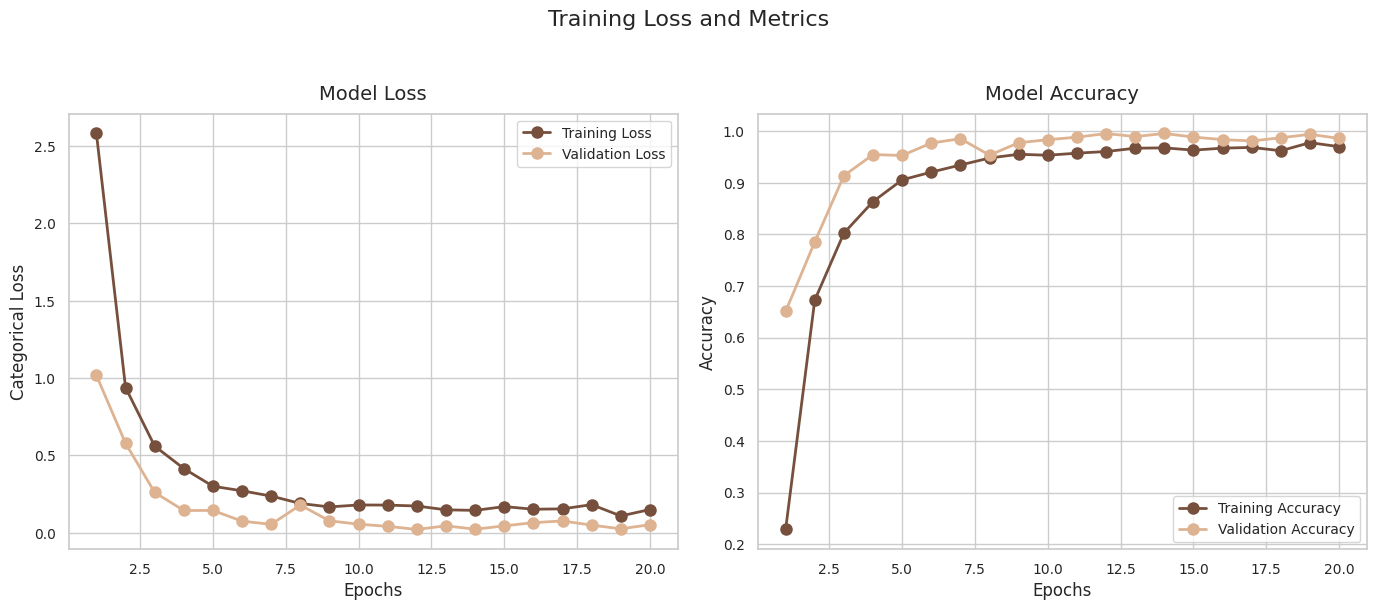

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration for the plot
class PlotCFG:
    train_color = "#76503d"
    valid_color = "#deb392"
    marker_size = 8
    line_width = 2
    figsize = (14, 6)

# Extract data from history
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = np.arange(1, len(loss) + 1)

# Set Seaborn style
sns.set_style("whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=PlotCFG.figsize)

# Loss Plot
axes[0].plot(
    epochs, loss, 
    label="Training Loss", 
    color=PlotCFG.train_color, 
    marker='o', markersize=PlotCFG.marker_size, linewidth=PlotCFG.line_width
)
axes[0].plot(
    epochs, val_loss, 
    label="Validation Loss", 
    color=PlotCFG.valid_color, 
    marker='o', markersize=PlotCFG.marker_size, linewidth=PlotCFG.line_width
)
axes[0].set_title("Model Loss", fontsize=14, pad=10)
axes[0].set_xlabel("Epochs", fontsize=12)
axes[0].set_ylabel("Categorical Loss", fontsize=12)
axes[0].legend(loc="upper right", fontsize=10)
axes[0].tick_params(axis='both', which='major', labelsize=10)

# Accuracy Plot
axes[1].plot(
    epochs, acc, 
    label="Training Accuracy", 
    color=PlotCFG.train_color, 
    marker='o', markersize=PlotCFG.marker_size, linewidth=PlotCFG.line_width
)
axes[1].plot(
    epochs, val_acc, 
    label="Validation Accuracy", 
    color=PlotCFG.valid_color, 
    marker='o', markersize=PlotCFG.marker_size, linewidth=PlotCFG.line_width
)
axes[1].set_title("Model Accuracy", fontsize=14, pad=10)
axes[1].set_xlabel("Epochs", fontsize=12)
axes[1].set_ylabel("Accuracy", fontsize=12)
axes[1].legend(loc="lower right", fontsize=10)
axes[1].tick_params(axis='both', which='major', labelsize=10)

# Adjust layout
plt.suptitle("Training Loss and Metrics", fontsize=16, y=1.02)
plt.tight_layout()

plt.savefig("trainning_metrics.png", dpi=500, bbox_inches="tight")

# Show the plot
plt.show()

<div>
    <h2 style = "color: #c7a48b; font-size: 22px; font-family: Calibri; font-weight: bold;">4.3. Confusion Matrix</h2>
</div>

13050/13050 [==============================] - 73s 6ms/step


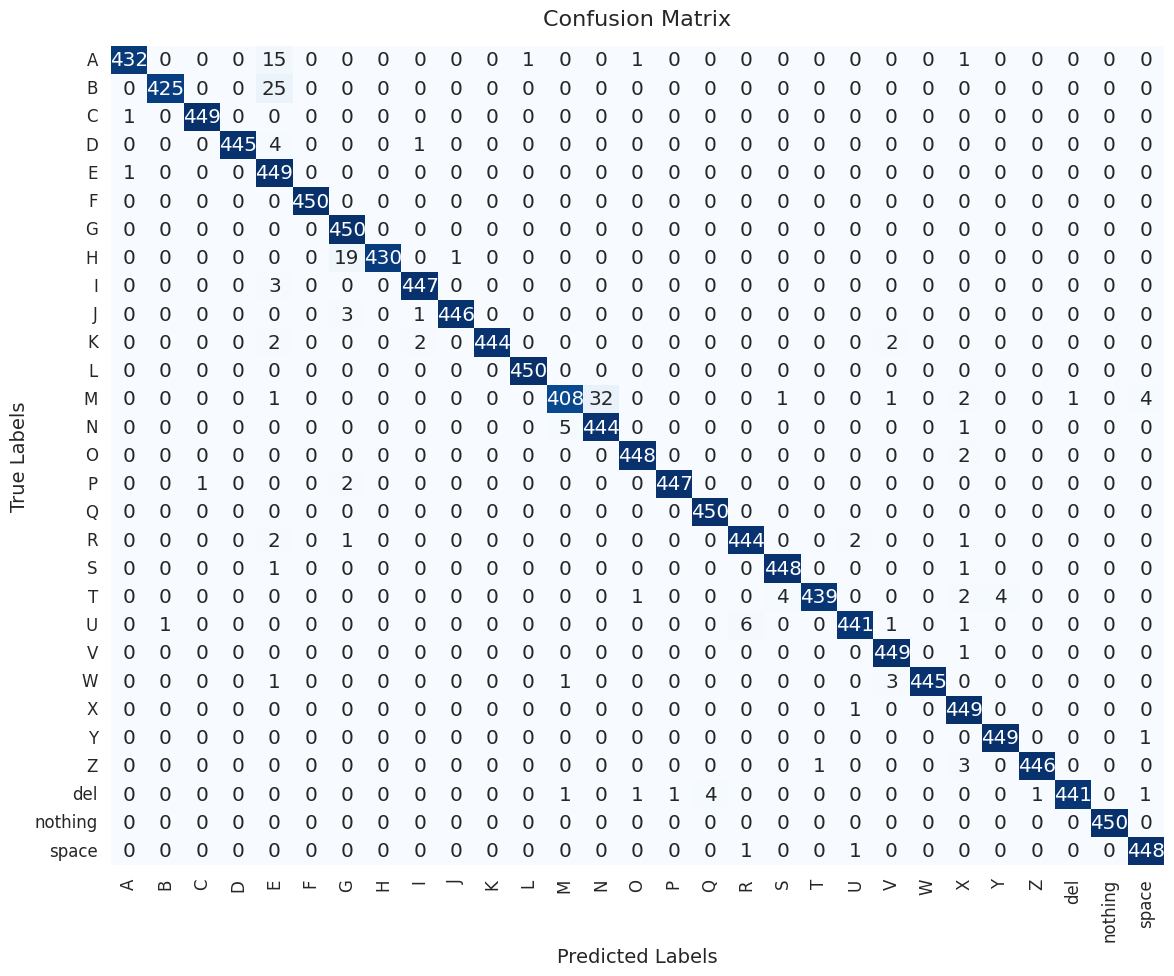

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix

# Load the fine-tuned model
fine_tuned_model = load_model("/kaggle/working/my_model_v1.keras")

# Generate predictions on the test data
predictions = fine_tuned_model.predict(test_generator)

# Get true labels from the generator
true_labels = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(
    y_true=true_labels,
    y_pred=np.argmax(predictions, axis=1)
)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(12, 10))
sns.set(font_scale=1.2)  # Adjust font size for better readability
sns.heatmap(
    cm,
    annot=True,  # Display values in the cells
    fmt="d",     # Format as integers
    cmap="Blues",  # Use a blue color palette
    xticklabels=test_generator.class_indices.keys(),  # Class labels for x-axis
    yticklabels=test_generator.class_indices.keys(),  # Class labels for y-axis
    cbar=False   # Disable color bar for cleaner visualization
)

# Add labels and title
plt.title("Confusion Matrix", fontsize=16, pad=15)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)

# Rotate x-axis and y-axis labels for better readability
plt.xticks(rotation=90, fontsize=12)
plt.yticks(rotation=0, fontsize=12)

plt.savefig("confusion_matrix.png", dpi=500, bbox_inches="tight")

# Show the plot
plt.tight_layout()
plt.show()

<div style = "color: Black; 
              display: fill;
              border-radius: 12px;
              background-color: #c7a48b;
              box-shadow: rgba(0, 0, 0, 0.15) 0px 10px 5px, rgba(0, 0, 0, 0.12) 0px 6px 6px;">
    <h1 id = "model-explainability"
        style = "padding: 13px; 
                 color: White;
                 font-size: 24px;
                 font-weight: bold;
                 font-family: Calibri;">5. | Model Explainability
        <a class="anchor-link" id="model-explainability" href="https://www.kaggle.com/code/harits/vgg16-asl-recognition-model-explainability#model-explainability">¶</a>
    </h1>
</div>

<div>
    <h2 style = "color: #c7a48b; font-size: 22px; font-family: Calibri; font-weight: bold;">5.1. t-SNE Visualization</h2>
</div>

In [44]:
dense_model = Model(inputs=fine_tuned_model.inputs, outputs=fine_tuned_model.layers[-3].output)
dense_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [45]:
print(labels)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [46]:
# Extract Features in Dense Layer
def dense_feature_prediction(img_path):
    img = load_img(img_path, target_size=(CFG.img_height, CFG.img_width))
    img = img_to_array(img)
    img = img / 255.
    img = np.expand_dims(img, axis=0)
    dense_feature = dense_model.predict(img, verbose=0)[0]
    return dense_feature

reduction_data = pd.DataFrame()
for label in labels:
    label_data = data_test[data_test["label"]==label][:100]
    reduction_data = reduction_data.append(label_data)

reduction_data = reduction_data.reset_index(drop=True)
display(reduction_data)

dense_features = reduction_data["image_path"].progress_apply(dense_feature_prediction)
dense_features = pd.DataFrame.from_records(dense_features.values, index=dense_features.index)

image_path  label
0     /kaggle/input/asl-alphabet/asl_alphabet_train/...      A
1     /kaggle/input/asl-alphabet/asl_alphabet_train/...      A
2     /kaggle/input/asl-alphabet/asl_alphabet_train/...      A
3     /kaggle/input/asl-alphabet/asl_alphabet_train/...      A
4     /kaggle/input/asl-alphabet/asl_alphabet_train/...      A
...                                                 ...    ...
2895  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space
2896  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space
2897  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space
2898  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space
2899  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space

[2900 rows x 2 columns]

100%|██████████| 2900/2900 [03:02<00:00, 15.87it/s]


In [47]:
# tSNE Dimensional Reduction
tsne = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_features = tsne.fit_transform(dense_features)
tsne_features = pd.DataFrame(tsne_features, columns=["tsne_feat_0", "tsne_feat_1"])
reduction_data[["tsne_feat_0", "tsne_feat_1"]] = tsne_features
reduction_data

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2900 samples in 0.003s...
[t-SNE] Computed neighbors for 2900 samples in 0.402s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2900
[t-SNE] Computed conditional probabilities for sample 2000 / 2900
[t-SNE] Computed conditional probabilities for sample 2900 / 2900
[t-SNE] Mean sigma: 10.526754
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.736423
[t-SNE] KL divergence after 1000 iterations: 0.514478


image_path  label  tsne_feat_0  \
0     /kaggle/input/asl-alphabet/asl_alphabet_train/...      A    -8.232590   
1     /kaggle/input/asl-alphabet/asl_alphabet_train/...      A    -9.702305   
2     /kaggle/input/asl-alphabet/asl_alphabet_train/...      A    -8.528547   
3     /kaggle/input/asl-alphabet/asl_alphabet_train/...      A    -8.691351   
4     /kaggle/input/asl-alphabet/asl_alphabet_train/...      A    -9.972918   
...                                                 ...    ...          ...   
2895  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space     8.974752   
2896  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space    10.730146   
2897  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space    10.621428   
2898  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space     8.164573   
2899  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space    11.274065   

      tsne_feat_1  
0       12.024304  
1       14.408475  
2       13.776548  
3       15.858506  
4       14.404962  
...           ...  
2895   -28.938272  
2896   -37.236416  
2897   -34.693291  
2898   -29.256002  
2899   -36.824936  

[2900 rows x 4 columns]

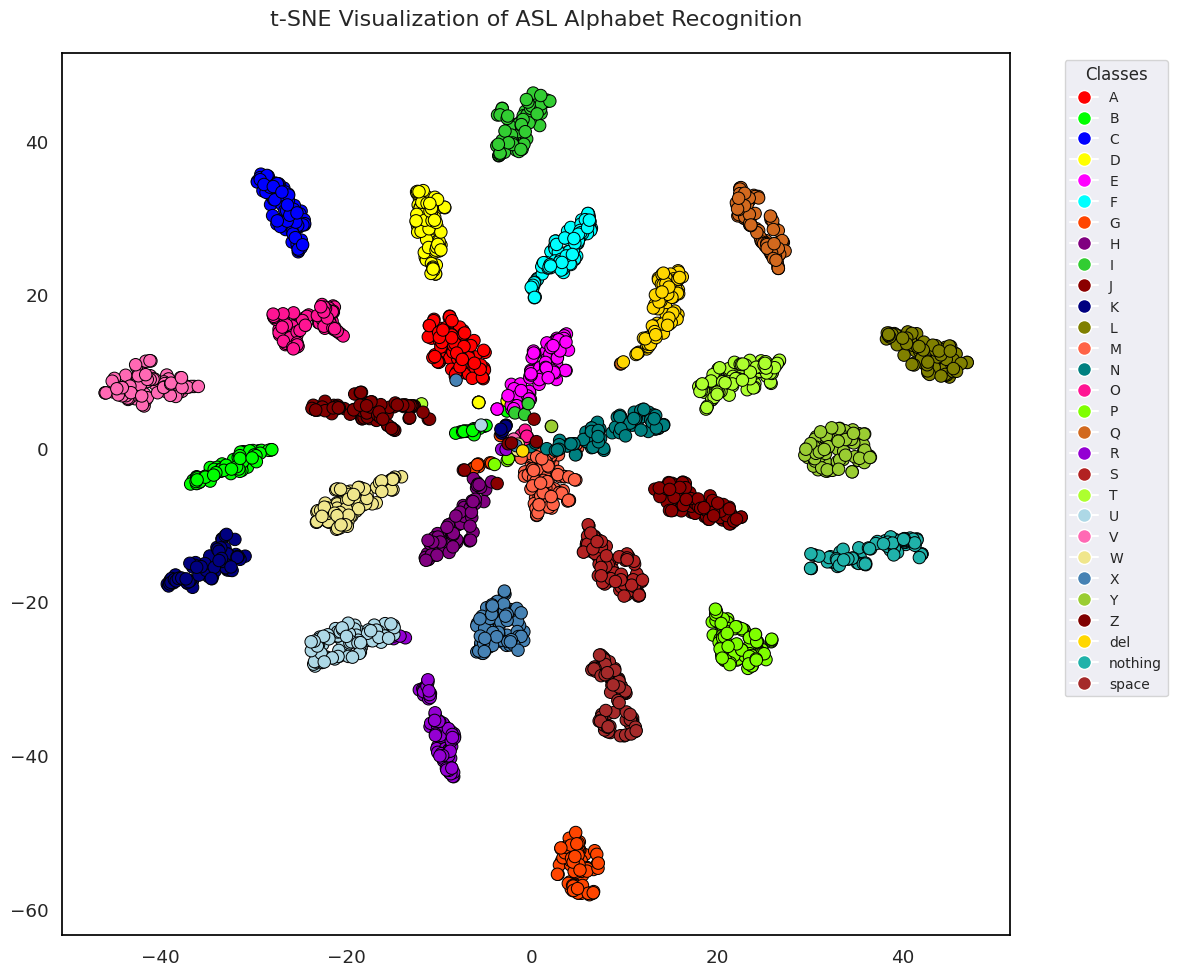

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the list of colors
list_colors = [
    "#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#FF00FF", "#00FFFF", "#FF4500", "#800080", "#32CD32", "#8B0000",
    "#000080", "#808000", "#FF6347", "#008080", "#FF1493", "#7FFF00", "#D2691E", "#9400D3", "#B22222", "#ADFF2F",
    "#ADD8E6", "#FF69B4", "#F0E68C", "#4682B4", "#9ACD32", "#800000", "#FFD700", "#20B2AA", "#A52A2A"
]

# Define the ASL class labels
class_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 
                'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 
                'del', 'nothing', 'space']

# Ensure the reduction_data DataFrame has columns: 'tsne_feat_0', 'tsne_feat_1', and 'label'
# Example structure:
# reduction_data = pd.DataFrame({
#     "tsne_feat_0": [...],
#     "tsne_feat_1": [...],
#     "label": [...]
# })


reduction_data['label_name'] = reduction_data['label']

# Create the scatter plot using Seaborn
plt.figure(figsize=(12, 10))
scatter = sns.scatterplot(
    data=reduction_data,
    x="tsne_feat_0",
    y="tsne_feat_1",
    hue="label_name",  # Use the mapped class names for coloring
    palette={label: color for label, color in zip(class_labels, list_colors)},  # Explicit color mapping
    s=80,  # Marker size
    edgecolor="black",  # Add a black border around markers for better visibility
    legend=False  # Disable Seaborn's default legend
)

# Customize the axes
scatter.set(xlabel="", ylabel="")
scatter.xaxis.set_tick_params(color="black")
scatter.yaxis.set_tick_params(color="black")
scatter.spines['top'].set_color('black')
scatter.spines['bottom'].set_color('black')
scatter.spines['left'].set_color('black')
scatter.spines['right'].set_color('black')

# Set the background color to white
scatter.set_facecolor("white")

# Add a title
plt.title("t-SNE Visualization of ASL Alphabet Recognition", fontsize=16, pad=20)

# Create a custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
           for label, color in zip(class_labels, list_colors)]
plt.legend(
    handles=handles,
    title="Classes",  # Title for the legend
    bbox_to_anchor=(1.05, 1),  # Place the legend outside the plot
    loc="upper left",  # Position relative to the anchor
    fontsize=10,  # Font size for legend entries
    title_fontsize=12  # Font size for the legend title
)

plt.savefig("tsne_scatter_plot_with_legend.png", dpi=500, bbox_inches="tight")

# Show the plot
plt.tight_layout()
plt.show()

<div>
    <h2 style = "color: #c7a48b; font-size: 22px; font-family: Calibri; font-weight: bold;">5.2. Class Activation Maps (Grad-CAM)</h2>
</div>

In [58]:
# https://pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()
            
    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
            
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
        
    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])
        
        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
            
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)
        
        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        
        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
        
        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        
        # return the resulting heatmap to the calling function
        return heatmap
    
    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap=cv2.COLORMAP_VIRIDIS):
        
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [59]:
def gradcam_images(labels):
    # Create Subplots
    fig, axs = plt.subplots(len(labels), 7, figsize=(12, 10))

    for i, label in enumerate(labels):
        axs[i, 0].text(0.5, 0.5, label, ha='center', va='center', fontsize=8)
        axs[i, 0].axis('off')
        
        label_data = data_test[data_test["label"]==label][:2].reset_index(drop=True)

        for j in range(2):
            # Read Original Image
            orig = cv2.imread(label_data["image_path"][j])
            orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
            
            # Preprocess and Predict Label from Image
            img = load_img(label_data["image_path"][j], target_size=(CFG.img_height, CFG.img_width))
            img = img_to_array(img) / 255.
            img = np.expand_dims(img, axis=0)
            img_label_ci = fine_tuned_model.predict(img, verbose=0)
            img_label = np.argmax(img_label_ci[0])
            
            # Compute Heatmap using GradCAM
            cam = GradCAM(fine_tuned_model, img_label)
            heatmap = cam.compute_heatmap(img)
            
            # Overlay Heatmap with Original Image
            heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
            (heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)
            
            # Show Original, Heatmap, and Overlap Heatmap Images
            axs[i, j*3+1].imshow(orig)
            axs[i, j*3+1].axis("off")
            axs[i, j*3+2].imshow(heatmap)
            axs[i, j*3+2].axis("off")
            axs[i, j*3+3].imshow(output)
            axs[i, j*3+3].axis("off")

    # Title
    plt.suptitle("Class Activation Maps (GradCAM) in Test Images", x=0.55, y=0.92)

    # Show
    plt.show()

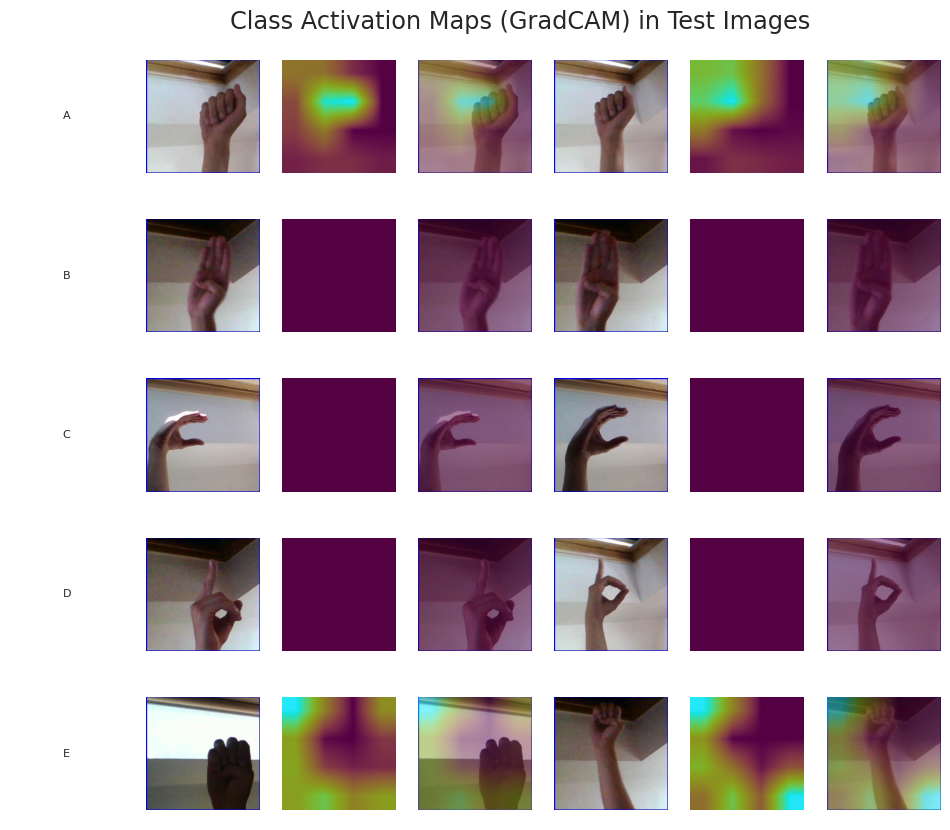

In [60]:
gradcam_images(labels[:5])

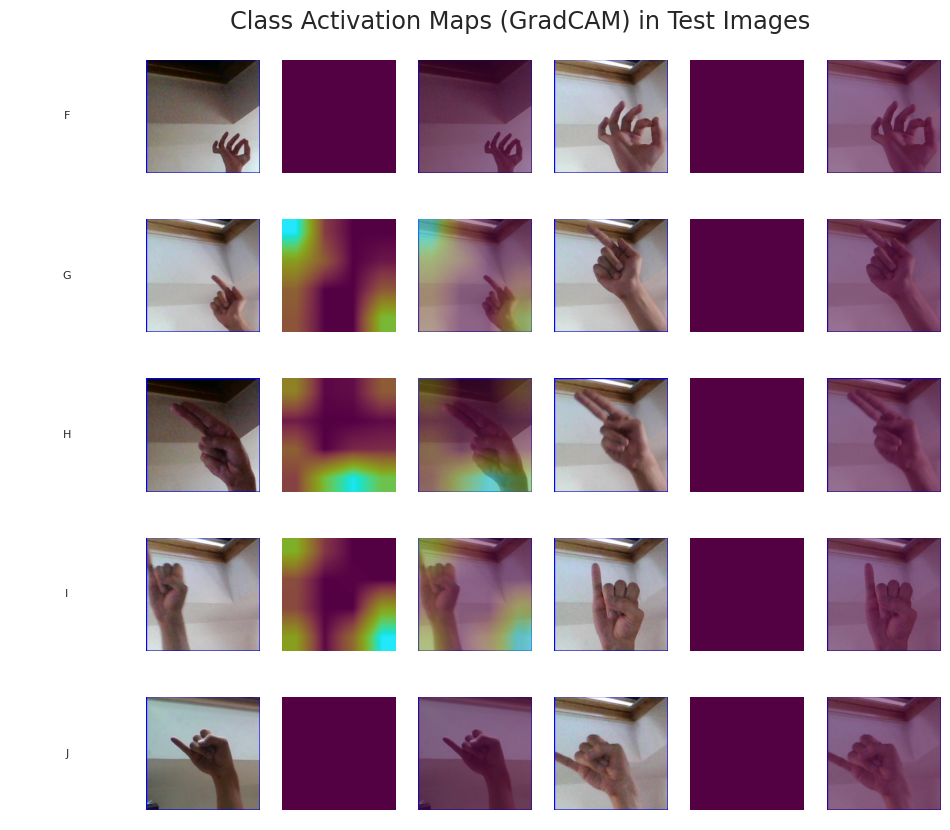

In [61]:
gradcam_images(labels[5:10])

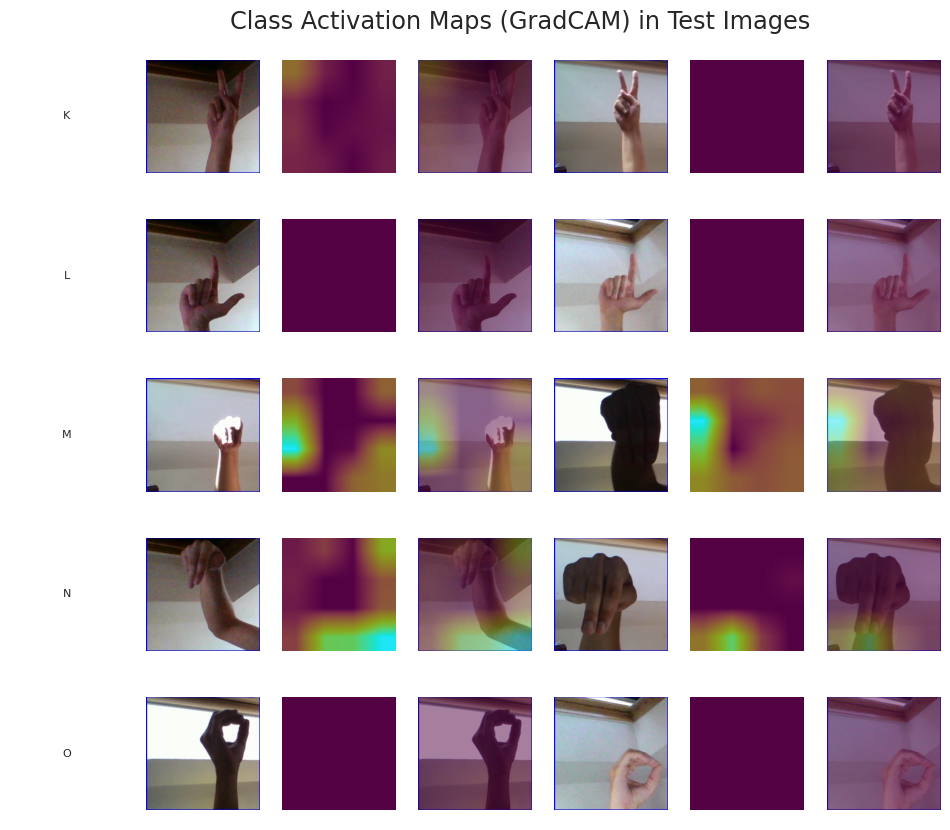

In [62]:
gradcam_images(labels[10:15])